**SECTION 1: ENVIRONMENT SETUP AND DATA LOADING**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [ ]:
!pip install -q findspark
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("PySpark Analysis").getOrCreate())

In [ ]:
ipl_ball_by_ball = spark.read.csv(header = True, inferSchema = True, path = 'ipl_ball_by_ball.csv')
ipl_ball_by_ball.printSchema()
ipl_ball_by_ball.show(3)

root
 |-- match_id: integer (nullable = true)
 |-- inning: integer (nullable = true)
 |-- overs: integer (nullable = true)
 |-- ball: integer (nullable = true)
 |-- batsman: string (nullable = true)
 |-- non_striker: string (nullable = true)
 |-- bowler: string (nullable = true)
 |-- batsman_runs: integer (nullable = true)
 |-- extra_runs: integer (nullable = true)
 |-- total_runs: integer (nullable = true)
 |-- non_boundary: integer (nullable = true)
 |-- is_wicket: integer (nullable = true)
 |-- dismissal_kind: string (nullable = true)
 |-- player_dismissed: string (nullable = true)
 |-- fielder: string (nullable = true)
 |-- extras_type: string (nullable = true)
 |-- batting_team: string (nullable = true)
 |-- bowling_team: string (nullable = true)

+--------+------+-----+----+-------------+-------------+------------+------------+----------+----------+------------+---------+--------------+----------------+-------+-----------+--------------------+--------------+
|match_id|inning|over

In [ ]:
ipl_matches = spark.read.csv(header = True, inferSchema = True, path = 'ipl_matches.csv')
ipl_venue = spark.read.csv(header = True, inferSchema = True, path = 'ipl_venue.csv')
ipl_matches.createOrReplaceTempView("schema_view")
  
ipl_matches = spark.sql('''
SELECT 
  match_id,
  DATE(date),
  player_of_match,
  venue_id,
  neutral_venue,
  team1,
  team2,
  toss_winner,
  toss_decision,
  winner,
  result,
  INT(result_margin),
  eliminator,
  method,
  umpire1,
  umpire2
FROM schema_view
''')
  
ipl_matches.printSchema()
ipl_matches.show(2)
ipl_venue.printSchema()
ipl_venue.show(2)

root
 |-- match_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- player_of_match: string (nullable = true)
 |-- venue_id: integer (nullable = true)
 |-- neutral_venue: integer (nullable = true)
 |-- team1: string (nullable = true)
 |-- team2: string (nullable = true)
 |-- toss_winner: string (nullable = true)
 |-- toss_decision: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- result: string (nullable = true)
 |-- result_margin: integer (nullable = true)
 |-- eliminator: string (nullable = true)
 |-- method: string (nullable = true)
 |-- umpire1: string (nullable = true)
 |-- umpire2: string (nullable = true)

+--------+----------+---------------+--------+-------------+--------------------+--------------------+--------------------+-------------+--------------------+------+-------------+----------+------+---------+-----------+
|match_id|      date|player_of_match|venue_id|neutral_venue|               team1|               team2|         toss_winner|

In [ ]:
#Check whether dataset has any missing values
from pyspark.sql.functions import isnan, when, count, col 
ipl_ball_by_ball.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ipl_ball_by_ball.columns]).show(vertical=True)

-RECORD 0---------------
 match_id         | 0   
 inning           | 0   
 overs            | 0   
 ball             | 0   
 batsman          | 0   
 non_striker      | 0   
 bowler           | 0   
 batsman_runs     | 0   
 extra_runs       | 0   
 total_runs       | 0   
 non_boundary     | 0   
 is_wicket        | 0   
 dismissal_kind   | 0   
 player_dismissed | 0   
 fielder          | 0   
 extras_type      | 0   
 batting_team     | 0   
 bowling_team     | 0   



In [ ]:
ipl_venue.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ipl_venue.columns]).show(vertical=True)

-RECORD 0-------
 venue_id | 0   
 venue    | 0   
 city     | 0   



In [ ]:
ipl_matches.select(*[
    (
        count(when((isnan(c) | col(c).isNull()), c)) if t not in ("timestamp", "date")
        else count(when(col(c).isNull(), c))
    ).alias(c)
    for c, t in ipl_matches.dtypes
]).show(vertical=True)

-RECORD 0--------------
 match_id        | 0   
 date            | 0   
 player_of_match | 0   
 venue_id        | 0   
 neutral_venue   | 0   
 team1           | 0   
 team2           | 0   
 toss_winner     | 0   
 toss_decision   | 0   
 winner          | 0   
 result          | 0   
 result_margin   | 0   
 eliminator      | 0   
 method          | 0   
 umpire1         | 0   
 umpire2         | 0   



In [ ]:
ipl_matches = ipl_matches.fillna({'result_margin':'0'}) #For removing null values in result_margin column


In [ ]:
ipl_ball_by_ball.createOrReplaceTempView("balls")
ipl_matches.createOrReplaceTempView("matches")
ipl_venue.createOrReplaceTempView("venue")

**SECTION 2: USING pySpark FOR DATA ANALYSIS**

In [ ]:
# 1st question
spark.sql(
"""
select b.venue,count(a.venue_id) from matches a
inner join venue b on a.venue_id=b.venue_id
where a.eliminator = 'Y'
group by b.venue
order by 2 desc;
""").show(3)

+--------------------+---------------+
|               venue|count(venue_id)|
+--------------------+---------------+
|Dubai Internation...|              3|
|Sheikh Zayed Stadium|              2|
|    Feroz Shah Kotla|              1|
+--------------------+---------------+
only showing top 3 rows



In [ ]:
#2nd question
spark.sql(
"""
select fielder,count(*) as catches from balls
where dismissal_kind == 'caught'
group by fielder
order by count(1) desc
"""
).show(1)

+----------+-------+
|   fielder|catches|
+----------+-------+
|KD Karthik|    118|
+----------+-------+
only showing top 1 row



In [ ]:
#3rd question
from pyspark.sql.functions import sum
merged=ipl_ball_by_ball.join(ipl_matches,on='match_id')
DL=merged[merged['method']=='D/L']
sum1=DL.groupBy(['match_id', 'bowler']).agg(sum("is_wicket").alias("Wickets Taken"))

from pyspark.sql.window import Window
from pyspark.sql.functions import rank
from pyspark.sql.functions import col

window = Window.partitionBy('match_id').orderBy(col('Wickets Taken').desc())
res_4=sum1.withColumn('rank',rank().over(window))
res_4.filter(res_4.rank==1).sort('Wickets Taken', ascending=False).show()

+--------+----------------+-------------+----+
|match_id|          bowler|Wickets Taken|rank|
+--------+----------------+-------------+----+
|  392183|      DL Vettori|            5|   1|
|  980943|        AB Dinda|            4|   1|
|  336025|         M Ntini|            4|   1|
|  980999|       YS Chahal|            4|   1|
| 1136592|        TA Boult|            3|   1|
| 1082648| NM Coulter-Nile|            3|   1|
| 1136592|      JD Unadkat|            3|   1|
| 1136566|        S Nadeem|            3|   1|
|  980997|        AB Dinda|            3|   1|
|  980997|         A Zampa|            3|   1|
|  501255|   CK Langeveldt|            2|   1|
|  980989|        R Ashwin|            2|   1|
| 1136578|Mujeeb Ur Rahman|            2|   1|
| 1136578|          AJ Tye|            2|   1|
|  733993|        DW Steyn|            2|   1|
|  501215|        R Ashwin|            2|   1|
|  733993|    MC Henriques|            2|   1|
|  392186|      SC Ganguly|            2|   1|
|  829807|   

In [ ]:
#4th question
legal=ipl_ball_by_ball[(~ipl_ball_by_ball['extras_type'].isin(['wides', 'noballs'])) & (ipl_ball_by_ball['overs'].between(6,19))]
runs=legal.groupBy('batsman').sum('batsman_runs')
ball=legal.groupby('batsman').count()
balls=ball.withColumnRenamed("batsman","batsman_1")
joined=balls.join(runs, balls.batsman_1 == runs.batsman, 'inner')
result_4=joined.withColumn("Strike rate", col("sum(batsman_runs)")*100/col("count")).sort('Strike rate',ascending=False)
result_4.select('batsman','Strike rate').show(10)

+------------+------------------+
|     batsman|       Strike rate|
+------------+------------------+
|  B Stanlake|             250.0|
|  ER Dwivedi|211.11111111111111|
|Kamran Akmal| 208.1081081081081|
|    Umar Gul|205.26315789473685|
|    RS Sodhi|             200.0|
|   LJ Wright|184.31372549019608|
|  AD Russell| 182.1078431372549|
|Vishnu Vinod|             180.0|
|    V Sehwag|             175.0|
|TU Deshpande|             175.0|
+------------+------------------+
only showing top 10 rows



In [ ]:
#5th question
spark.sql(
"""
select c.venue,c.city,a.match_id,a.inning,SUM(a.extra_runs) AS Extra_Runs from balls a 
inner join matches b on a.match_id=b.match_id
inner join venue c on b.venue_id=c.venue_id
group by c.venue,c.city,a.match_id,a.inning
order by Extra_Runs desc;
""").show()

+--------------------+--------------+--------+------+----------+
|               venue|          city|match_id|inning|Extra_Runs|
+--------------------+--------------+--------+------+----------+
|        Eden Gardens|       Kolkata|  335986|     2|        28|
|Himachal Pradesh ...|    Dharamsala|  501260|     1|        27|
|Sawai Mansingh St...|        Jaipur|  336023|     1|        26|
|    St George's Park|Port Elizabeth|  392227|     2|        26|
|   Brabourne Stadium|        Mumbai|  829811|     2|        26|
|    Wankhede Stadium|        Mumbai|  733983|     1|        25|
|     SuperSport Park|     Centurion|  392235|     1|        24|
|Holkar Cricket St...|        Indore|  501254|     1|        23|
|    Wankhede Stadium|        Mumbai|  336028|     2|        23|
|M.Chinnaswamy Sta...|     Bengaluru| 1136591|     2|        23|
|Punjab Cricket As...|    Chandigarh|  501251|     1|        22|
|Maharashtra Crick...|          Pune|  829709|     1|        21|
|Sawai Mansingh St...|   

In [ ]:
#6th question
spark.sql(
"""
select player_of_match,count(player_of_match) from matches
where neutral_venue = 1
group by player_of_match
order by count(player_of_match) desc 
""").show()

+----------------+----------------------+
| player_of_match|count(player_of_match)|
+----------------+----------------------+
|       JP Duminy|                     3|
|      GJ Maxwell|                     3|
|       YK Pathan|                     3|
|       JH Kallis|                     3|
|    Yuvraj Singh|                     2|
|     LRPL Taylor|                     2|
|  Sandeep Sharma|                     2|
|    SR Tendulkar|                     2|
|        SK Raina|                     2|
|       RG Sharma|                     2|
|       ML Hayden|                     2|
|DPMD Jayawardene|                     2|
|        DR Smith|                     2|
|   KC Sangakkara|                     2|
|  M Muralitharan|                     2|
|       MK Pandey|                     2|
|  AB de Villiers|                     2|
|    AC Gilchrist|                     2|
|     S Badrinath|                     1|
|        R Dravid|                     1|
+----------------+----------------

In [ ]:
#7th question
player_dismissed=ipl_ball_by_ball.groupby('player_dismissed').count()
total_runs=ipl_ball_by_ball.groupBy('batsman').sum('batsman_runs')
joined_data=player_dismissed.join(total_runs, player_dismissed.player_dismissed == total_runs.batsman, 'inner') 
result_7=joined_data.withColumn("Batsmen Avg", col("sum(batsman_runs)")/col("count")).sort('Batsmen Avg',ascending=False)
result_7.select('batsman','Batsmen Avg').show(10)

+-------------+------------------+
|      batsman|       Batsmen Avg|
+-------------+------------------+
|   MN van Wyk|55.666666666666664|
|   RD Gaikwad|              51.0|
|     AC Voges|             45.25|
|     KL Rahul| 44.86440677966102|
|      HM Amla| 44.38461538461539|
|Iqbal Abdulla|              44.0|
|    DA Warner| 42.71544715447155|
|  JM Bairstow|41.578947368421055|
|     CH Gayle| 41.13793103448276|
|     MS Dhoni|40.991150442477874|
+-------------+------------------+
only showing top 10 rows



In [ ]:
#8th question
spark.sql(
"""
select umpire, count(*)
from ((select umpire1 as umpire from matches) union all
      (select umpire2 from matches)
     ) matches
group by umpire
order by count(*) desc ;
""").show()

+--------------------+--------+
|              umpire|count(1)|
+--------------------+--------+
|              S Ravi|     121|
|     HDPK Dharmasena|      94|
|        AK Chaudhary|      87|
|       C Shamshuddin|      82|
|           M Erasmus|      65|
|           CK Nandan|      57|
|         Nitin Menon|      57|
|          SJA Taufel|      55|
|           Asad Rauf|      51|
|         VA Kulkarni|      50|
|        BNJ Oxenford|      48|
|         CB Gaffaney|      47|
|           RJ Tucker|      46|
|         BR Doctrove|      42|
|         RE Koertzen|      41|
|           Aleem Dar|      38|
|           BF Bowden|      37|
|            NJ Llong|      37|
|KN Ananthapadmana...|      33|
|      RK Illingworth|      31|
+--------------------+--------+
only showing top 20 rows



In [ ]:
#9th question
spark.sql(
"""
select m.match_id,first(v.venue),first(v.city),sum(b.batsman_runs) from balls as b
inner join matches as m on b.match_id=m.match_id
inner join venue as v on m.venue_id =v.venue_id
where b.batsman= 'V Kohli'
group by m.match_id
order by sum(b.batsman_runs) desc limit 1; 
""").show()

+--------+--------------------+-----------+-----------------+
|match_id|        first(venue)|first(city)|sum(batsman_runs)|
+--------+--------------------+-----------+-----------------+
|  980999|M.Chinnaswamy Sta...|  Bengaluru|              113|
+--------+--------------------+-----------+-----------------+



In [ ]:
#10th question
win_count = 0
for index, value in ipl_matches.toPandas().iterrows():
  if (value['toss_winner'] == value['winner']):
    win_count += 1

print(f'The number of times the team winning toss have won: {win_count}')
prob = win_count/ipl_matches.count()
print('The probability of winning if won the toss: {:.2f}' .format(prob))

The number of times the team winning toss have won: 418
The probability of winning if won the toss: 0.51


**The probability of winning when the team had won the toss is 51%.** So winning toss gives a slight edge over the opponent. However, it would be naive to term winning the toss as a greater advantage as there were 398 instances when the team losing the toss has won the game.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Toss Result Analysis')

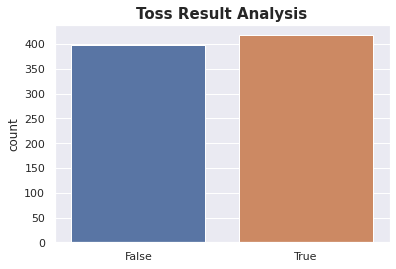

In [ ]:
# DATA VISUALIZATION 
import seaborn as sns
ipl_pd_df = ipl_matches.toPandas()
ss = ipl_pd_df['toss_winner'] == ipl_pd_df['winner']
ss.groupby(ss).size()
sns.set_theme(style="darkgrid")
ax = sns.countplot(ss);
ax.set_title("Toss Result Analysis",fontdict= { 'fontsize': 15, 'fontweight':'bold'})

**SECTION 3: EXPOSE DATA**

In [ ]:
! pip install pyodbc

In [ ]:
import pyodbc
class IplData:
  def __init__(self):
    self.conn = pyodbc.connect(
        "Driver={SQL Server for Native Client 11.0};"
        "Server=.;"
        "Database=IplData;"
        "Trusted_Connection=yes;"
    )

    self.cur = self.conn.cursor()

  def get_query1_results(self):
    self.cur.execute("""select b.venue,count(a.venue_id) from matches a
                       inner join venue b on a.venue_id=b.venue_id
                       where a.eliminator = 'Y'
                       group by b.venue
                       order by 2 desc;""")
    q1 = self.cur.fetchone()
    return q1

  def get_query2_results(self):
    self.cur.execute("""select fielder,count(*) as catches from balls
                        where dismissal_kind == 'caught'
                        group by fielder
                        order by count(1) desc""")
    q2 = self.cur.fetchone()
    return q2

  def get_query4_results(self):
    self.cur.execute("""legal=ipl_ball_by_ball[(~ipl_ball_by_ball['extras_type'].isin(['wides', 'noballs'])) & (ipl_ball_by_ball['overs'].between(6,19))]
                        runs=legal.groupBy('batsman').sum('batsman_runs')
                        ball=legal.groupby('batsman').count()
                        balls=ball.withColumnRenamed("batsman","batsman_1")
                        joined=balls.join(runs, balls.batsman_1 == runs.batsman, 'inner')
                        result_4=joined.withColumn("Strike rate", col("sum(batsman_runs)")*100/col("count")).sort('Strike rate',ascending=False)
                        result_4.select('batsman','Strike rate').show(10)""")
    q4 = self.cur.fetchone()
    return q4

  def get_query5_results(self):
    self.cur.execute("""select c.venue,c.city,a.match_id,a.inning,SUM(a.extra_runs) AS Extra_Runs from balls a 
                        inner join matches b on a.match_id=b.match_id
                        inner join venue c on b.venue_id=c.venue_id
                        group by c.venue,c.city,a.match_id,a.inning
                        order by Extra_Runs desc;""")
    q5 = self.cur.fetchone()
    return q5

  def get_query6_results(self):
    self.cur.execute("""select player_of_match,count(player_of_match) from matches
                        where neutral_venue = 1
                        group by player_of_match
                        order by count(player_of_match) desc """)
    q6 = self.cur.fetchone()
    return q6

  def get_query7_results(self):
    self.cur.execute("""player_dismissed=ipl_ball_by_ball.groupby('player_dismissed').count()
                        total_runs=ipl_ball_by_ball.groupBy('batsman').sum('batsman_runs')
                        joined_data=player_dismissed.join(total_runs, player_dismissed.player_dismissed == total_runs.batsman, 'inner') 
                        result_7=joined_data.withColumn("Batsmen Avg", col("sum(batsman_runs)")/col("count")).sort('Batsmen Avg',ascending=False)
                        result_7.select('batsman','Batsmen Avg').show(10)""")
    q7 = self.cur.fetchone()
    return q7

  def get_query8_results(self):
    self.cur.execute("""select umpire, count(*)
                        from ((select umpire1 as umpire from matches) union all
                              (select umpire2 from matches)
                              ) matches
                              group by umpire
                        order by count(*) desc ;""")
    q8 = self.cur.fetchone()
    return q8

  def get_query9_results(self):
    self.cur.execute("""select m.match_id,first(v.venue),first(v.city),sum(b.batsman_runs) from balls as b
                        inner join matches as m on b.match_id=m.match_id
                        inner join venue as v on m.venue_id =v.venue_id
                        where b.batsman= 'V Kohli'
                        group by m.match_id
                        order by sum(b.batsman_runs) desc limit 1;""")
    q9 = self.cur.fetchone()
    return q9
   

  